# March Madness Pre-Game Prediction Model

This notebook builds a machine learning model to predict game outcomes **before** they happen using:
1. Historical team performance features (rolling statistics)
2. Temporal train/test split (first 80% vs last 20% of games per season)
3. Logistic regression baseline model

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries imported")
print(f"Working directory: {Path.cwd()}")

✓ Libraries imported
Working directory: /users/bzheng2/Private/March-Madness-Predictor


## 1. Load and Prepare Data

In [19]:
# Load processed data
df = pd.read_csv("processed_data/ncaa_basketball_processed_2003_2023.csv")

# Convert dates and sort chronologically (CRITICAL for temporal features)
df['game_date'] = pd.to_datetime(df['game_date'])
df = df.sort_values(['season', 'game_date', 'game_id']).reset_index(drop=True)

print(f"✓ Data loaded: {df.shape}")
print(f"  Records: {len(df):,}")
print(f"  Seasons: {df['season'].min()}-{df['season'].max()}")
print(f"  Date range: {df['game_date'].min().date()} to {df['game_date'].max().date()}")

✓ Data loaded: (211432, 43)
  Records: 211,432
  Seasons: 2003-2023
  Date range: 2003-03-10 to 2023-04-03


## 2. Feature Engineering - Rolling Statistics

Create pre-game features using only historical data (no future leakage).

In [20]:
print("Creating historical features...")

# Define stats to track
stats = ['team_score', 'field_goal_pct', 'three_point_field_goal_pct', 
         'total_rebounds', 'assists', 'team_turnovers']
stats = [s for s in stats if s in df.columns]

# Calculate rolling averages (last 5 games, excluding current game)
for stat in stats:
    df[f'{stat}_L5'] = df.groupby(['team_id', 'season'])[stat].transform(
        lambda x: x.shift(1).rolling(5, min_periods=1).mean()
    )

# Win rate (last 5 games)
df['win_rate_L5'] = df.groupby(['team_id', 'season'])['team_winner_encoded'].transform(
    lambda x: x.shift(1).rolling(5, min_periods=1).mean()
)

# Games played this season (before current game)
df['games_played'] = df.groupby(['team_id', 'season']).cumcount()

# Season win rate (before current game)
df['season_wins'] = df.groupby(['team_id', 'season'])['team_winner_encoded'].transform(
    lambda x: x.shift(1).expanding().sum()
).fillna(0)
df['season_win_rate'] = df.apply(
    lambda row: row['season_wins'] / row['games_played'] if row['games_played'] > 0 else 0.5,
    axis=1
)

print(f"✓ Created {len([c for c in df.columns if '_L5' in c or 'season_' in c])} features")
print(f"  Total columns: {len(df.columns)}")

Creating historical features...
✓ Created 11 features
  Total columns: 53


## 3. Create Matchup Dataset

Transform from team-level records to matchup-level (Team A vs Team B).

In [48]:
print("Creating matchup dataset...")

# Get complete games (both teams present)
game_counts = df.groupby('game_id').size()
complete_games = game_counts[game_counts == 2].index
df_complete = df[df['game_id'].isin(complete_games)].copy()

print(f"  Complete games: {len(complete_games):,}")

# Build matchup records
matchups = []
feature_cols = [c for c in df.columns if '_L5' in c or 'win_rate' in c or 'season_win' in c or 'games_played' in c]

for game_id in complete_games:
    game = df_complete[df_complete['game_id'] == game_id]
    if len(game) != 2:
        continue
    
    team_a, team_b = game.iloc[0], game.iloc[1]
    
    # Randomly shuffle which team is "Team A" to balance win/loss distribution
    if np.random.random() > 0.5:
        team_a, team_b = team_b, team_a
    
    matchup = {
        'game_id': game_id,
        'season': team_a['season'],
        'game_date': team_a['game_date'],
        'team_a_id': team_a['team_id'],
        'team_b_id': team_b['team_id'],
        'team_a_home': int(team_a.get('home_away_encoded', 0) == 1),
        'team_a_won': int(team_a.get('team_winner_encoded', 0))
    }
    
    # Add differential features (Team A - Team B)
    for col in feature_cols:
        if pd.notna(team_a[col]) and pd.notna(team_b[col]):
            matchup[f'diff_{col}'] = team_a[col] - team_b[col]
    
    matchups.append(matchup)

df_matchups = pd.DataFrame(matchups)
df_matchups['game_date'] = pd.to_datetime(df_matchups['game_date'])

print(f"✓ Matchups created: {len(df_matchups):,}")
print(f"  Features: {len([c for c in df_matchups.columns if 'diff_' in c])} differential features")

# Check class balance
print(f"\nClass distribution:")
win_count = (df_matchups['team_a_won'] == 1).sum()
loss_count = (df_matchups['team_a_won'] == 0).sum()
print(f"  Team A Wins:   {win_count:,} ({win_count/len(df_matchups)*100:.1f}%)")
print(f"  Team A Losses: {loss_count:,} ({loss_count/len(df_matchups)*100:.1f}%)")

print(f"\nSample:")
display(df_matchups[['game_id', 'season', 'team_a_id', 'team_b_id', 'team_a_home', 'team_a_won']].head())

Creating matchup dataset...
  Complete games: 105,716
✓ Matchups created: 105,716
  Features: 0 differential features

Class distribution:
  Team A Wins:   52,878 (50.0%)
  Team A Losses: 52,838 (50.0%)

Sample:


,game_id,season,team_a_id,team_b_id,team_a_home,team_a_won
0,230682250,2003,2608,2250,1,0
1,233280269,2004,269,128,1,1
2,233300013,2004,13,38,1,0
3,233300052,2004,52,2447,1,1
4,233300099,2004,2653,99,0,0


## 4. Temporal Train/Test Split

For each season, use first 80% of games for training and last 20% for testing.

In [49]:
print("Performing temporal split...")

# Clean data
df_clean = df_matchups.dropna(subset=['team_a_won']).copy()
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(0)

print(f"  Clean matchups: {len(df_clean):,}")

# Split by season: first 80% train, last 20% test
train_list = []
test_list = []

for season in df_clean['season'].unique():
    season_data = df_clean[df_clean['season'] == season].sort_values('game_date')
    n = len(season_data)
    split_idx = int(n * 0.8)
    
    train_list.append(season_data.iloc[:split_idx])
    test_list.append(season_data.iloc[split_idx:])

train_df = pd.concat(train_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

print(f"\n✓ Temporal split completed:")
print(f"  Train: {len(train_df):,} matchups ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"  Test:  {len(test_df):,} matchups ({len(test_df)/len(df_clean)*100:.1f}%)")
print(f"\n  Train date range: {train_df['game_date'].min().date()} to {train_df['game_date'].max().date()}")
print(f"  Test date range:  {test_df['game_date'].min().date()} to {test_df['game_date'].max().date()}")

Performing temporal split...
  Clean matchups: 105,716

✓ Temporal split completed:
  Train: 84,565 matchups (80.0%)
  Test:  21,151 matchups (20.0%)

  Train date range: 2003-11-24 to 2023-02-15
  Test date range:  2003-03-10 to 2023-04-03


## 5. Prepare Features and Target

In [50]:
# Select features
exclude = ['game_id', 'season', 'game_date', 'team_a_id', 'team_b_id', 'team_a_won']
feature_cols = [c for c in df_clean.columns if c not in exclude]

X_train = train_df[feature_cols].copy()
y_train = train_df['team_a_won'].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df['team_a_won'].copy()

print(f"Features: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\nClass distribution:")
print(f"  Train - Win: {y_train.mean():.1%}, Loss: {(1-y_train.mean()):.1%}")
print(f"  Test  - Win: {y_test.mean():.1%}, Loss: {(1-y_test.mean()):.1%}")

Features: 1

Feature list:
   1. team_a_home

Class distribution:
  Train - Win: 50.0%, Loss: 50.0%
  Test  - Win: 49.9%, Loss: 50.1%


## 6. Scale Features

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled (StandardScaler)")

✓ Features scaled (StandardScaler)


## 7. Train Logistic Regression Model

In [52]:
print("Training logistic regression model...")

model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced'
)

model.fit(X_train_scaled, y_train)

print(f"✓ Model trained (converged in {model.n_iter_[0]} iterations)")

Training logistic regression model...
✓ Model trained (converged in 2 iterations)


## 8. Evaluate Model

In [53]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("="*70)
print("MODEL PERFORMANCE")
print("="*70)

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")

print("\nTEST SET:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")

print("\n" + classification_report(y_test, y_test_pred, target_names=['Loss', 'Win']))

MODEL PERFORMANCE

TRAIN SET:
  Accuracy:  0.5489
  Precision: 0.5492


  Recall:    0.5497
  F1-Score:  0.5495
  ROC-AUC:   0.5489

TEST SET:
  Accuracy:  0.5324
  Precision: 0.5318
  Recall:    0.5310
  F1-Score:  0.5314
  ROC-AUC:   0.5324

              precision    recall  f1-score   support

        Loss       0.53      0.53      0.53     10590
         Win       0.53      0.53      0.53     10561

    accuracy                           0.53     21151
   macro avg       0.53      0.53      0.53     21151
weighted avg       0.53      0.53      0.53     21151



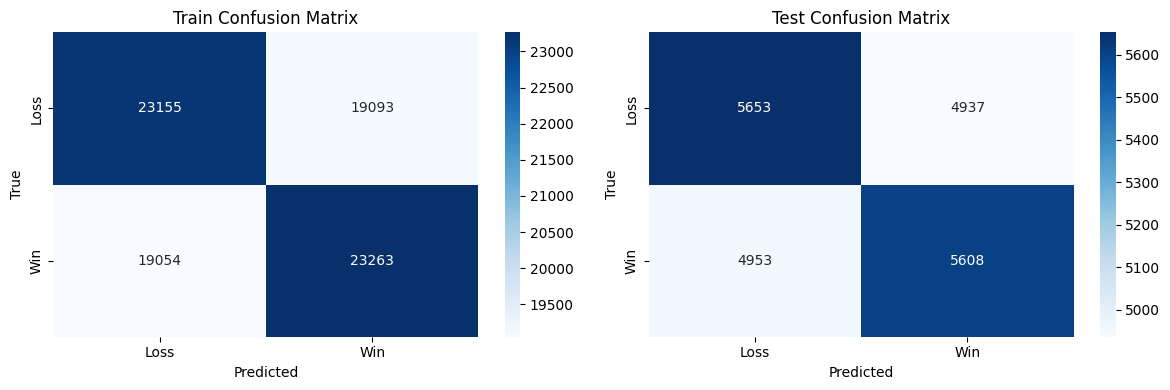

In [54]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

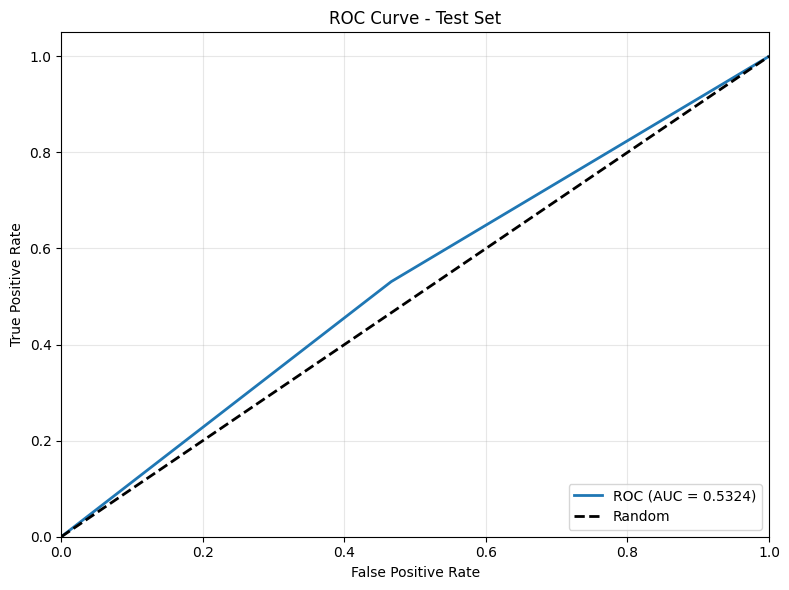

In [55]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Feature Importance


Top 10 Most Important Features:
  team_a_home                               -0.1962 ↓


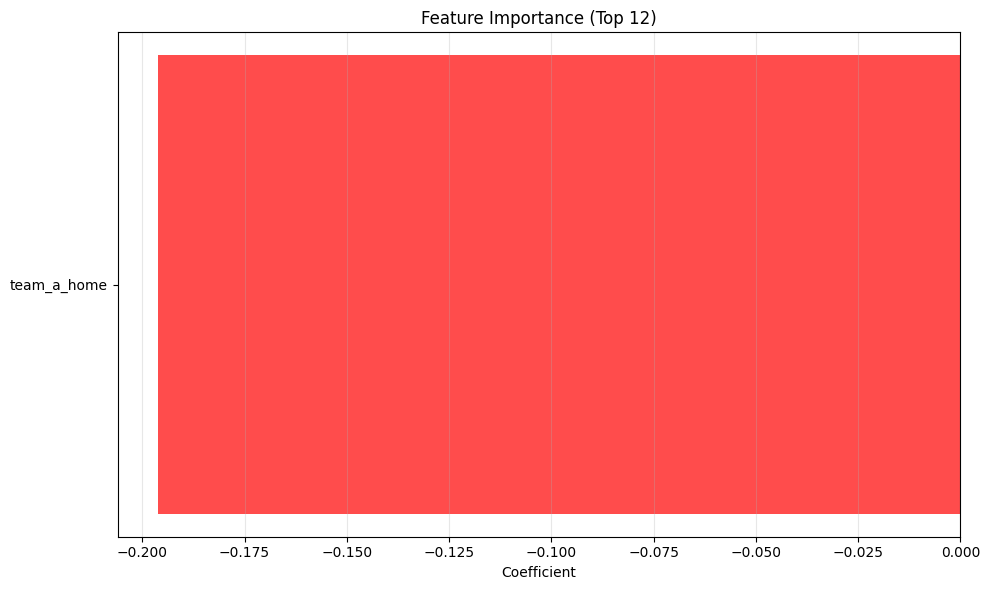

In [56]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Most Important Features:")
print("="*70)
for idx, row in feature_importance.head(10).iterrows():
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    print(f"  {row['Feature']:<40} {row['Coefficient']:>8.4f} {direction}")

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(12)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient')
plt.title('Feature Importance (Top 12)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Summary

In [57]:
print("="*70)
print("SUMMARY")
print("="*70)
print(f"\n📊 Dataset: {len(df_clean):,} matchups")
print(f"   Train: {len(train_df):,} | Test: {len(test_df):,}")
print(f"\n🎯 Model: Logistic Regression")
print(f"   Features: {len(feature_cols)} (historical rolling stats)")
print(f"   Split: Temporal 80/20 per season")
print(f"\n📈 Performance:")
print(f"   Test Accuracy: {accuracy_score(y_test, y_test_pred):.2%}")
print(f"   Test ROC-AUC:  {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"\n🔑 Top Predictor: {feature_importance.iloc[0]['Feature']}")
print(f"\n💡 Next Steps:")
print(f"   • Add more historical windows (L10, L15)")
print(f"   • Try Random Forest / XGBoost")
print(f"   • Add head-to-head features")
print(f"   • Implement Elo ratings")
print("="*70)

SUMMARY

📊 Dataset: 105,716 matchups
   Train: 84,565 | Test: 21,151

🎯 Model: Logistic Regression
   Features: 1 (historical rolling stats)
   Split: Temporal 80/20 per season

📈 Performance:
   Test Accuracy: 53.24%
   Test ROC-AUC:  0.5324

🔑 Top Predictor: team_a_home

💡 Next Steps:
   • Add more historical windows (L10, L15)
   • Try Random Forest / XGBoost
   • Add head-to-head features
   • Implement Elo ratings


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")
print(f"Current working directory: {Path.cwd()}")

Libraries imported successfully!
Current working directory: /users/bzheng2/Private/March-Madness-Predictor


## 1. Load Processed Data

Load the cleaned and processed dataset from the previous data preparation notebook.

In [59]:
# Load the processed data
data_path = Path("processed_data/ncaa_basketball_processed_2003_2023.csv")

if data_path.exists():
    df = pd.read_csv(data_path)
    print(f"✓ Data loaded successfully!")
    print(f"  File: {data_path}")
    print(f"  Shape: {df.shape}")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {df.shape[1]}")
else:
    print(f"✗ ERROR: File not found at {data_path}")
    print(f"  Please run the data preparation notebook first to generate the processed data.")

✓ Data loaded successfully!
  File: processed_data/ncaa_basketball_processed_2003_2023.csv
  Shape: (211432, 43)
  Rows: 211,432
  Columns: 43


In [60]:
# Display basic information
print("\nDATASET OVERVIEW:")
print("="*60)
print(f"Total records: {len(df):,}")
print(f"Date range: {df['season'].min()} to {df['season'].max()}")
print(f"\nFirst few rows:")
display(df.head())

print(f"\nColumn names:")
print(df.columns.tolist())


DATASET OVERVIEW:
Total records: 211,432
Date range: 2003 to 2023

First few rows:


,team_location,team_id,field_goals_made_field_goals_attempted,field_goal_pct,three_point_field_goals_made_three_point_field_goals_attempted,three_point_field_goal_pct,free_throws_made_free_throws_attempted,free_throw_pct,total_rebounds,offensive_rebounds,defensive_rebounds,team_rebounds,assists,steals,blocks,turnovers,team_turnovers,total_turnovers,technical_fouls,total_technical_fouls,flagrant_fouls,fouls,game_id,season,season_type,game_date,game_date_time,team_score,team_winner,field_goals_made,field_goals_attempted,free_throws_made,free_throws_attempted,three_point_field_goals_made,three_point_field_goals_attempted,opponent_team_location,opponent_team_score,largest_lead,home_away_combined,opponent_id_combined,season_type_encoded,home_away_encoded,team_winner_encoded
0,Saint Mary's,2608,16-45,35.6,4-11,36.4,16-23,69.6,34,10,20,4.0,7,3,3,18,0,18,0,0,0,21,230682250,2003,2,2003-03-10,NaN,52.0,False,16.0,45.0,16.0,23.0,4.0,11.0,Gonzaga,73.0,NaN,home,2250.0,0,1,0
1,Gonzaga,2250,24-55,43.6,4-10,40.0,21-27,77.8,41,12,23,6.0,9,10,3,8,0,8,0,0,0,20,230682250,2003,2,2003-03-10,NaN,73.0,True,24.0,55.0,21.0,27.0,4.0,10.0,Saint Mary's,52.0,NaN,away,2608.0,0,0,1
2,Illinois,356,23-56,41.1,2-15,13.3,3-8,37.5,38,16,20,2.0,17,6,2,22,1,22,0,0,0,20,233432507,2004,2,2003-12-09,2003-12-10 00:00:00+00:00,51.0,False,23.0,56.0,3.0,8.0,2.0,15.0,Providence,70.0,NaN,away,2507.0,0,0,0
3,Providence,2507,26-60,43.3,7-16,43.8,11-19,57.9,44,19,20,5.0,14,10,7,14,0,14,0,0,0,12,233432507,2004,2,2003-12-09,2003-12-10 00:00:00+00:00,70.0,True,26.0,60.0,11.0,19.0,7.0,16.0,Illinois,51.0,NaN,home,356.0,0,1,1
4,Colorado,38,28-63,44.4,1-10,10.0,16-23,69.6,48,12,33,3.0,9,9,6,14,0,14,0,0,0,17,233300013,2004,2,2003-11-26,2003-11-27 03:00:00+00:00,73.0,True,28.0,63.0,16.0,23.0,1.0,10.0,Cal Poly,62.0,NaN,away,13.0,0,0,1



Column names:
['team_location', 'team_id', 'field_goals_made_field_goals_attempted', 'field_goal_pct', 'three_point_field_goals_made_three_point_field_goals_attempted', 'three_point_field_goal_pct', 'free_throws_made_free_throws_attempted', 'free_throw_pct', 'total_rebounds', 'offensive_rebounds', 'defensive_rebounds', 'team_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'team_turnovers', 'total_turnovers', 'technical_fouls', 'total_technical_fouls', 'flagrant_fouls', 'fouls', 'game_id', 'season', 'season_type', 'game_date', 'game_date_time', 'team_score', 'team_winner', 'field_goals_made', 'field_goals_attempted', 'free_throws_made', 'free_throws_attempted', 'three_point_field_goals_made', 'three_point_field_goals_attempted', 'opponent_team_location', 'opponent_team_score', 'largest_lead', 'home_away_combined', 'opponent_id_combined', 'season_type_encoded', 'home_away_encoded', 'team_winner_encoded']


## 2. Feature Selection and Data Preparation

Select features for modeling, handling missing values, and prepare the target variable.

In [61]:
print("FEATURE SELECTION AND DATA PREPARATION")
print("="*70)

# Define target variable
target_col = 'team_winner_encoded' if 'team_winner_encoded' in df.columns else 'team_winner'

# Define columns to exclude from features
exclude_cols = [
    # Identifiers
    'game_id', 'team_id', 'opponent_id_combined',
    
    # Dates (use season instead)
    'game_date', 'game_date_time',
    
    # Target variables (and their raw versions)
    'team_winner', 'team_winner_encoded',
    
    # Location information (already have encoded version)
    'team_location', 'opponent_team_location',
    
    # Raw categorical features (use encoded versions)
    'season_type', 'home_away_combined',
    
    # Combined format columns (use individual made/attempted columns)
    'field_goals_made_field_goals_attempted',
    'three_point_field_goals_made_three_point_field_goals_attempted',
    'free_throws_made_free_throws_attempted',
]

# Get all columns
all_cols = df.columns.tolist()

# Select feature columns (exclude target and non-feature columns)
feature_cols = [col for col in all_cols if col not in exclude_cols]

print(f"Total columns in dataset: {len(all_cols)}")
print(f"Excluded columns: {len(exclude_cols)}")
print(f"Feature columns selected: {len(feature_cols)}")
print(f"Target variable: {target_col}")

FEATURE SELECTION AND DATA PREPARATION
Total columns in dataset: 43
Excluded columns: 14
Feature columns selected: 29
Target variable: team_winner_encoded


In [62]:
# Check for missing values in features and target
print("\nCHECKING MISSING VALUES:")
print("="*60)

# Check target variable
target_missing = df[target_col].isnull().sum()
print(f"\nTarget variable '{target_col}': {target_missing:,} missing ({target_missing/len(df)*100:.2f}%)")

# Check feature columns
print(f"\nFeature columns with missing values:")
missing_counts = df[feature_cols].isnull().sum()
missing_features = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_features) > 0:
    print(f"Found {len(missing_features)} features with missing values:\n")
    for col, count in missing_features.items():
        pct = count / len(df) * 100
        print(f"  {col:<40}: {count:>8,} ({pct:>5.1f}%)")
else:
    print("  ✓ No missing values found in feature columns!")


CHECKING MISSING VALUES:

Target variable 'team_winner_encoded': 0 missing (0.00%)

Feature columns with missing values:
Found 2 features with missing values:

  largest_lead                            :   27,112 ( 12.8%)
  team_rebounds                           :   12,370 (  5.9%)


In [63]:
# Remove rows with missing target variable
print("\nCLEANING DATA:")
print("="*60)

initial_rows = len(df)
df_clean = df.dropna(subset=[target_col]).copy()
rows_removed = initial_rows - len(df_clean)

print(f"Rows with missing target removed: {rows_removed:,}")
print(f"Remaining rows: {len(df_clean):,}")

# For features, only keep rows where ALL features are non-null
df_clean = df_clean.dropna(subset=feature_cols)
final_rows = len(df_clean)
total_removed = initial_rows - final_rows

print(f"\nRows with any missing features removed: {initial_rows - final_rows:,}")
print(f"Final dataset size: {final_rows:,} rows ({final_rows/initial_rows*100:.1f}% of original)")

# Check class distribution
print(f"\nTARGET CLASS DISTRIBUTION:")
class_dist = df_clean[target_col].value_counts()
class_pct = df_clean[target_col].value_counts(normalize=True) * 100

for class_val in sorted(class_dist.index):
    label = "Loss" if class_val == 0 else "Win"
    print(f"  {label} ({class_val}): {class_dist[class_val]:,} ({class_pct[class_val]:.1f}%)")

# Check for class imbalance
imbalance_ratio = class_dist.max() / class_dist.min()
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print("  ⚠ Warning: Significant class imbalance detected")
else:
    print("  ✓ Classes are reasonably balanced")


CLEANING DATA:
Rows with missing target removed: 0
Remaining rows: 211,432

Rows with any missing features removed: 39,382
Final dataset size: 172,050 rows (81.4% of original)

TARGET CLASS DISTRIBUTION:
  Loss (0): 86,026 (50.0%)
  Win (1): 86,024 (50.0%)

Class imbalance ratio: 1.00:1
  ✓ Classes are reasonably balanced


## 3. Train/Test Split

Split the data into training and testing sets. We'll use 80% for training and 20% for testing.

In [64]:
print("TRAIN/TEST SPLIT")
print("="*70)

# Prepare features (X) and target (y)
X = df_clean[feature_cols].copy()
y = df_clean[target_col].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y  # Maintain class distribution in both sets
)

print(f"\nSPLIT RESULTS:")
print(f"  Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set:     {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify class distribution in splits
print(f"\nClass distribution in training set:")
train_dist = y_train.value_counts(normalize=True) * 100
for class_val in sorted(train_dist.index):
    label = "Loss" if class_val == 0 else "Win"
    print(f"  {label}: {train_dist[class_val]:.1f}%")

print(f"\nClass distribution in test set:")
test_dist = y_test.value_counts(normalize=True) * 100
for class_val in sorted(test_dist.index):
    label = "Loss" if class_val == 0 else "Win"
    print(f"  {label}: {test_dist[class_val]:.1f}%")

print("\n✓ Data split completed successfully!")

TRAIN/TEST SPLIT
Features shape: (172050, 29)
Target shape: (172050,)

Feature columns (29):
   1. field_goal_pct
   2. three_point_field_goal_pct
   3. free_throw_pct
   4. total_rebounds
   5. offensive_rebounds
   6. defensive_rebounds
   7. team_rebounds
   8. assists
   9. steals
  10. blocks
  11. turnovers
  12. team_turnovers
  13. total_turnovers
  14. technical_fouls
  15. total_technical_fouls
  16. flagrant_fouls
  17. fouls
  18. season
  19. team_score
  20. field_goals_made
  21. field_goals_attempted
  22. free_throws_made
  23. free_throws_attempted
  24. three_point_field_goals_made
  25. three_point_field_goals_attempted
  26. opponent_team_score
  27. largest_lead
  28. season_type_encoded
  29. home_away_encoded

SPLIT RESULTS:
  Training set: 137,640 samples (80.0%)
  Test set:     34,410 samples (20.0%)

Class distribution in training set:
  Loss: 50.0%
  Win: 50.0%

Class distribution in test set:
  Loss: 50.0%
  Win: 50.0%

✓ Data split completed successfully!


## 4. Feature Scaling

Scale features to have mean=0 and std=1 for better model performance.

In [65]:
print("FEATURE SCALING")
print("="*70)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled using StandardScaler")
print(f"  Training set scaled shape: {X_train_scaled.shape}")
print(f"  Test set scaled shape: {X_test_scaled.shape}")

# Show scaling statistics for a few features
print(f"\nScaling statistics (first 5 features):")
print(f"  Feature means: {scaler.mean_[:5].round(2)}")
print(f"  Feature stds:  {scaler.scale_[:5].round(2)}")

print("\n✓ Feature scaling completed!")

FEATURE SCALING
✓ Features scaled using StandardScaler
  Training set scaled shape: (137640, 29)
  Test set scaled shape: (34410, 29)

Scaling statistics (first 5 features):
  Feature means: [43.82 34.27 69.35 36.71 10.81]
  Feature stds:  [ 7.64 11.57 12.77  7.49  4.21]

✓ Feature scaling completed!


## 5. Train Logistic Regression Model

Train a baseline logistic regression model to predict wins/losses.

In [66]:
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*70)

# Initialize model
model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'  # Handle any slight class imbalance
)

print("Training model...")
print(f"  Model: Logistic Regression")
print(f"  Solver: lbfgs")
print(f"  Max iterations: 1000")
print(f"  Class weight: balanced")

# Train the model
model.fit(X_train_scaled, y_train)

print(f"\n✓ Model training completed!")
print(f"  Converged: {model.n_iter_[0] < 1000}")
print(f"  Iterations: {model.n_iter_[0]}")

TRAINING LOGISTIC REGRESSION MODEL
Training model...
  Model: Logistic Regression
  Solver: lbfgs
  Max iterations: 1000
  Class weight: balanced

✓ Model training completed!
  Converged: True
  Iterations: 29


## 6. Model Evaluation

Evaluate model performance on both training and test sets.

In [67]:
print("MODEL EVALUATION")
print("="*70)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Predict probabilities for ROC-AUC
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("\nTRAINING SET PERFORMANCE:")
print("-"*40)
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")

print("\nTEST SET PERFORMANCE:")
print("-"*40)
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")

# Check for overfitting
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
acc_diff = train_acc - test_acc

print(f"\nOVERFITTING CHECK:")
print("-"*40)
print(f"  Train accuracy: {train_acc:.4f}")
print(f"  Test accuracy:  {test_acc:.4f}")
print(f"  Difference:     {acc_diff:.4f}")

if acc_diff < 0.02:
    print("  ✓ Excellent generalization - minimal overfitting")
elif acc_diff < 0.05:
    print("  ✓ Good generalization - slight overfitting")
else:
    print("  ⚠ Moderate overfitting detected")

MODEL EVALUATION

TRAINING SET PERFORMANCE:
----------------------------------------
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   1.0000

TEST SET PERFORMANCE:
----------------------------------------
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    0.9999
  F1-Score:  1.0000
  ROC-AUC:   1.0000

OVERFITTING CHECK:
----------------------------------------
  Train accuracy: 1.0000
  Test accuracy:  1.0000
  Difference:     0.0000
  ✓ Excellent generalization - minimal overfitting


In [68]:
# Detailed classification report
print("\nDETAILED CLASSIFICATION REPORT (Test Set):")
print("="*70)
print(classification_report(y_test, y_test_pred, target_names=['Loss (0)', 'Win (1)']))


DETAILED CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

    Loss (0)       1.00      1.00      1.00     17205
     Win (1)       1.00      1.00      1.00     17205

    accuracy                           1.00     34410
   macro avg       1.00      1.00      1.00     34410
weighted avg       1.00      1.00      1.00     34410



CONFUSION MATRIX


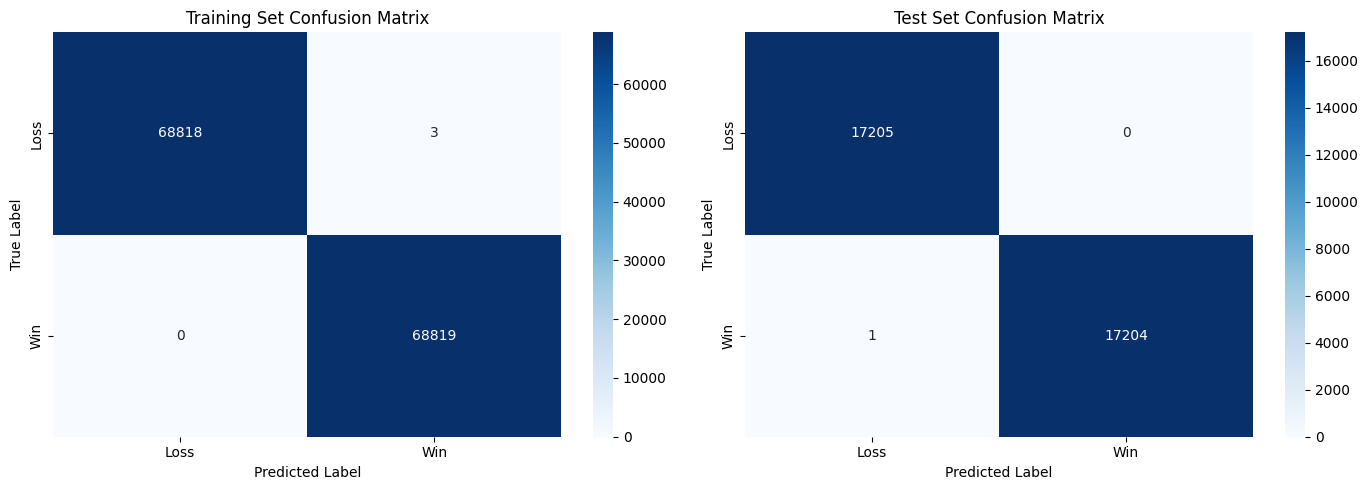


Test Set Confusion Matrix Values:
  True Negatives (Correct Loss predictions): 17,205
  False Positives (Loss predicted as Win):   0
  False Negatives (Win predicted as Loss):   1
  True Positives (Correct Win predictions):  17,204


In [69]:
# Confusion Matrix Visualization
print("CONFUSION MATRIX")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\nTest Set Confusion Matrix Values:")
print(f"  True Negatives (Correct Loss predictions): {cm_test[0, 0]:,}")
print(f"  False Positives (Loss predicted as Win):   {cm_test[0, 1]:,}")
print(f"  False Negatives (Win predicted as Loss):   {cm_test[1, 0]:,}")
print(f"  True Positives (Correct Win predictions):  {cm_test[1, 1]:,}")


ROC CURVE


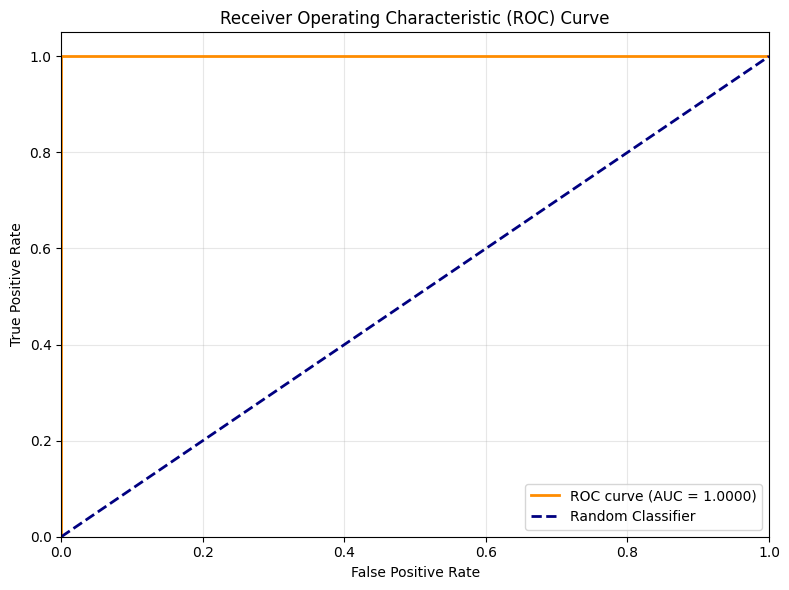

✓ ROC-AUC Score: 1.0000
  Excellent discrimination ability


In [70]:
# ROC Curve
print("\nROC CURVE")
print("="*70)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ ROC-AUC Score: {roc_auc:.4f}")
if roc_auc > 0.9:
    print("  Excellent discrimination ability")
elif roc_auc > 0.8:
    print("  Good discrimination ability")
elif roc_auc > 0.7:
    print("  Acceptable discrimination ability")
else:
    print("  Poor discrimination ability")

## 7. Feature Importance Analysis

Analyze which features are most important for predicting wins/losses.

In [71]:
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 20 Most Important Features:")
print("-"*70)
print(f"{'Rank':<6} {'Feature':<40} {'Coefficient':<12}")
print("-"*70)

for idx, (i, row) in enumerate(feature_importance.head(20).iterrows(), 1):
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    print(f"{idx:<6} {row['Feature']:<40} {row['Coefficient']:>10.4f} {direction}")

print("\n↑ = Positive correlation with winning")
print("↓ = Negative correlation with winning")

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
----------------------------------------------------------------------
Rank   Feature                                  Coefficient 
----------------------------------------------------------------------
1      opponent_team_score                        -32.1904 ↓
2      team_score                                  13.1712 ↑
3      field_goals_made                            10.4541 ↑
4      free_throws_made                             8.0794 ↑
5      three_point_field_goals_made                 5.4148 ↑
6      field_goal_pct                               3.7788 ↑
7      field_goals_attempted                        2.8639 ↑
8      free_throws_attempted                        0.7646 ↑
9      three_point_field_goals_attempted           -0.6634 ↓
10     three_point_field_goal_pct                  -0.6283 ↓
11     free_throw_pct                               0.2207 ↑
12     largest_lead                                 0.1620 ↑
13  

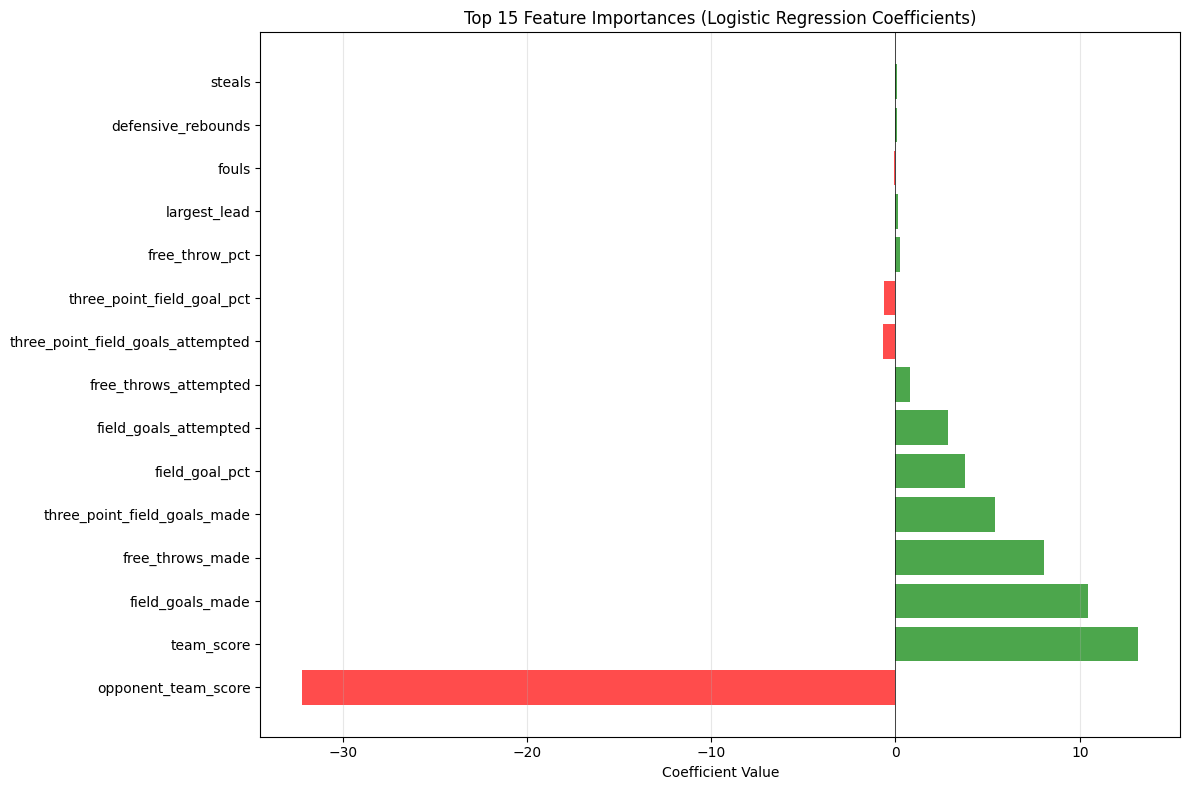


✓ Feature importance analysis completed!


In [72]:
# Visualize top feature importances
plt.figure(figsize=(12, 8))

top_features = feature_importance.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]

plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Importances (Logistic Regression Coefficients)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis completed!")

## 8. Cross-Validation

Perform k-fold cross-validation to ensure model robustness.

In [73]:
print("CROSS-VALIDATION")
print("="*70)

# Perform 5-fold cross-validation
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"\nCross-Validation Results:")
print("-"*40)
print(f"  Fold scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"  Mean accuracy: {cv_scores.mean():.4f}")
print(f"  Std deviation: {cv_scores.std():.4f}")
print(f"  95% confidence interval: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]")

print(f"\n✓ Cross-validation completed!")
print(f"  Model shows {'consistent' if cv_scores.std() < 0.01 else 'variable'} performance across folds")

CROSS-VALIDATION
Performing 5-fold cross-validation...

Cross-Validation Results:
----------------------------------------
  Fold scores: ['1.0000', '1.0000', '1.0000', '0.9999', '1.0000']
  Mean accuracy: 1.0000
  Std deviation: 0.0000
  95% confidence interval: [0.9999, 1.0000]

✓ Cross-validation completed!
  Model shows consistent performance across folds


## 9. Model Summary and Next Steps

Summary of model performance and recommendations for improvement.

In [74]:
print("="*70)
print("MODEL SUMMARY")
print("="*70)

print(f"\n📊 DATASET:")
print(f"  Total records: {len(df_clean):,}")
print(f"  Training set: {len(X_train):,}")
print(f"  Test set: {len(X_test):,}")
print(f"  Features: {len(feature_cols)}")

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"  Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"  Test ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"  Cross-Val Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\n🔑 TOP 5 PREDICTIVE FEATURES:")
for idx, (i, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"  {idx}. {row['Feature']} ({direction} win probability)")

print(f"\n💡 NEXT STEPS FOR IMPROVEMENT:")
print(f"  1. Try ensemble methods (Random Forest, XGBoost)")
print(f"  2. Feature engineering (create interaction features)")
print(f"  3. Hyperparameter tuning using GridSearchCV")
print(f"  4. Try different feature selection techniques")
print(f"  5. Consider temporal features (team momentum, recent performance)")
print(f"  6. Add opponent strength features (head-to-head stats)")

print("\n" + "="*70)
print("✓ Baseline model successfully created!")
print("  This model provides a solid foundation for predicting NCAA basketball game outcomes.")
print("="*70)

MODEL SUMMARY

📊 DATASET:
  Total records: 172,050
  Training set: 137,640
  Test set: 34,410
  Features: 29

🎯 MODEL PERFORMANCE:
  Test Accuracy: 1.0000
  Test F1-Score: 1.0000
  Test ROC-AUC: 1.0000
  Cross-Val Accuracy: 1.0000 ± 0.0000

🔑 TOP 5 PREDICTIVE FEATURES:
  1. opponent_team_score (decreases win probability)
  2. team_score (increases win probability)
  3. field_goals_made (increases win probability)
  4. free_throws_made (increases win probability)
  5. three_point_field_goals_made (increases win probability)

💡 NEXT STEPS FOR IMPROVEMENT:
  1. Try ensemble methods (Random Forest, XGBoost)
  2. Feature engineering (create interaction features)
  3. Hyperparameter tuning using GridSearchCV
  4. Try different feature selection techniques
  5. Consider temporal features (team momentum, recent performance)
  6. Add opponent strength features (head-to-head stats)

✓ Baseline model successfully created!
  This model provides a solid foundation for predicting NCAA basketball gam